# Machine Learning And End of Life Oil Production Forecast

Volve is a decommissioned offshore field in the central part of the North Sea and was discovered in 1993, the plan for development and operation (PDO) was approved in 2005. The field was shut down in 2016 and the formal removal and decommissioning will be completed by the end of 2018. One important decision prior to such decommissioning is to figure out the economic cut-off date. Knowing this date will help to plan for decommissioning phase in advance and help to produce the final profitable barrels. Now, calculating such cutoff date is not easy as different structure has different operating cost profile, depending on the number and type of producing wells, product type and quality, distance to shore, water production, age, workover requirements, market prices and other related factors. There are also other criteria beyond financial ones such as environmental, socioeconomic, and health and safety considerations.

### Source: https://data-equinor-com.azurewebsites.net/dataset/volve

Login and download *Production Data (1.9MB)*

In [2]:
%matplotlib inline

import numpy as np
import pandas as pd
from datetime import datetime
import statsmodels.api as sm
import scipy
import math
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display

from sklearn.linear_model    import LogisticRegression, LinearRegression  
from sklearn.svm             import SVC, SVR
from sklearn.ensemble        import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics         import accuracy_score, classification_report, mean_squared_error
from sklearn.pipeline        import make_pipeline
from sklearn.model_selection import train_test_split, KFold, cross_val_score

## Prediction choices

1 Original

In [3]:
#shuffle=True
#n_past_in, n_past_end, n_past_step = 20,0,1  # Predictors from t-20 to t

#features=['AVG_DOWNHOLE_PRESSURE', 'AVG_DOWNHOLE_TEMPERATURE',
#          'AVG_DP_TUBING','AVG_ANNULUS_PRESS', 'AVG_CHOKE_SIZE_P',
#          'AVG_WHP_P','AVG_WHT_P', 'DP_CHOKE_SIZE']

#target  =['MIN_3K_BOEPD_BINARY']  # classification
#target  =['BOEPD_PRODUCED_VOL']  # regression

2 Same as original but with no shuffling of data

In [4]:
shuffle=False
n_past_in, n_past_end, n_past_step = 20,0,1  # Predictors from t-20 to t

features=['AVG_DOWNHOLE_PRESSURE', 'AVG_DOWNHOLE_TEMPERATURE',
          'AVG_DP_TUBING','AVG_ANNULUS_PRESS', 'AVG_CHOKE_SIZE_P',
          'AVG_WHP_P','AVG_WHT_P', 'DP_CHOKE_SIZE']

target  =['MIN_3K_BOEPD_BINARY']  # classification
#target  =['BOEPD_PRODUCED_VOL']  # regression

3 Future prediction with 10 days lag 

In [5]:
#shuffle=False
#n_past_in, n_past_end, n_past_step = 30,10,1 # Predictors from t-30 to t-10

#features=['AVG_DOWNHOLE_PRESSURE', 'AVG_DOWNHOLE_TEMPERATURE',
#          'AVG_DP_TUBING','AVG_ANNULUS_PRESS', 'AVG_CHOKE_SIZE_P',
#          'AVG_WHP_P','AVG_WHT_P', 'DP_CHOKE_SIZE']

#target  =['MIN_3K_BOEPD_BINARY']  # classification
#target  =['BOEPD_PRODUCED_VOL']  # regression

4 Future prediction with 10 days lag (using also production from past)

In [6]:
#shuffle=False
#n_past_in, n_past_end, n_past_step = 30,10,1 # Predictors from t-30 to t-10

#features=['AVG_DOWNHOLE_PRESSURE', 'AVG_DOWNHOLE_TEMPERATURE',
#          'AVG_DP_TUBING','AVG_ANNULUS_PRESS', 'AVG_CHOKE_SIZE_P',
#          'AVG_WHP_P','AVG_WHT_P', 'DP_CHOKE_SIZE', 'BOEPD_PRODUCED_VOL']

#target  =['MIN_3K_BOEPD_BINARY']  # classification
#target  =['BOEPD_PRODUCED_VOL']  # regression

## Classifier/Regressor

In [7]:
#classification=True

#classifier = LogisticRegression()
classifier = SVC(kernel='linear',C=1.,random_state=4)
#classifier = RandomForestClassifier(random_state=4)

In [8]:
#classification=False

#classifier = LinearRegression()
#classifier = SVR(kernel='linear',C=1.,random_state=4)
#classifier = RandomForestRegressor(n_estimators=50, random_state=4)

## Data preparation

In [9]:
# Load the data
path1 = ("Production_data/Volve_production_data.xlsx")
original_data = pd.read_excel(path1, thousands=',')
original_data.head(5)

,DATEPRD,WELL_BORE_CODE,NPD_WELL_BORE_CODE,NPD_WELL_BORE_NAME,NPD_FIELD_CODE,NPD_FIELD_NAME,NPD_FACILITY_CODE,NPD_FACILITY_NAME,ON_STREAM_HRS,AVG_DOWNHOLE_PRESSURE,...,AVG_CHOKE_UOM,AVG_WHP_P,AVG_WHT_P,DP_CHOKE_SIZE,BORE_OIL_VOL,BORE_GAS_VOL,BORE_WAT_VOL,BORE_WI_VOL,FLOW_KIND,WELL_TYPE
0,2014-04-07,NO 15/9-F-1 C,7405,15/9-F-1 C,3420717,VOLVE,369304,MÆRSK INSPIRER,0.0,0.00000,...,%,0.00000,0.00000,0.00000,0.0,0.0,0.0,NaN,production,WI
1,2014-04-08,NO 15/9-F-1 C,7405,15/9-F-1 C,3420717,VOLVE,369304,MÆRSK INSPIRER,0.0,NaN,...,%,0.00000,0.00000,0.00000,0.0,0.0,0.0,NaN,production,OP
2,2014-04-09,NO 15/9-F-1 C,7405,15/9-F-1 C,3420717,VOLVE,369304,MÆRSK INSPIRER,0.0,NaN,...,%,0.00000,0.00000,0.00000,0.0,0.0,0.0,NaN,production,OP
3,2014-04-10,NO 15/9-F-1 C,7405,15/9-F-1 C,3420717,VOLVE,369304,MÆRSK INSPIRER,0.0,NaN,...,%,0.00000,0.00000,0.00000,0.0,0.0,0.0,NaN,production,OP
4,2014-04-11,NO 15/9-F-1 C,7405,15/9-F-1 C,3420717,VOLVE,369304,MÆRSK INSPIRER,0.0,310.37614,...,%,33.09788,10.47992,33.07195,0.0,0.0,0.0,NaN,production,OP


In [10]:
# Create a date index
original_data['DATETIME'] = pd.to_datetime(original_data['DATEPRD'])
original_data = original_data.set_index('DATETIME')
original_data = original_data.drop(['DATEPRD'], axis=1)
original_data.sort_index(inplace=True) # Sort by index time

In [11]:
# Checks column names
list(original_data.columns)

[u'WELL_BORE_CODE',
 u'NPD_WELL_BORE_CODE',
 u'NPD_WELL_BORE_NAME',
 u'NPD_FIELD_CODE',
 u'NPD_FIELD_NAME',
 u'NPD_FACILITY_CODE',
 u'NPD_FACILITY_NAME',
 u'ON_STREAM_HRS',
 u'AVG_DOWNHOLE_PRESSURE',
 u'AVG_DOWNHOLE_TEMPERATURE',
 u'AVG_DP_TUBING',
 u'AVG_ANNULUS_PRESS',
 u'AVG_CHOKE_SIZE_P',
 u'AVG_CHOKE_UOM',
 u'AVG_WHP_P',
 u'AVG_WHT_P',
 u'DP_CHOKE_SIZE',
 u'BORE_OIL_VOL',
 u'BORE_GAS_VOL',
 u'BORE_WAT_VOL',
 u'BORE_WI_VOL',
 u'FLOW_KIND',
 u'WELL_TYPE']

In [12]:
# Check the data type of each column by groupby
original_data.columns.to_series().groupby(original_data.dtypes).groups

{dtype('int64'): Index([u'NPD_WELL_BORE_CODE', u'NPD_FIELD_CODE', u'NPD_FACILITY_CODE'], dtype='object'),
 dtype('float64'): Index([u'ON_STREAM_HRS', u'AVG_DOWNHOLE_PRESSURE', u'AVG_DOWNHOLE_TEMPERATURE',
        u'AVG_DP_TUBING', u'AVG_ANNULUS_PRESS', u'AVG_CHOKE_SIZE_P',
        u'AVG_WHP_P', u'AVG_WHT_P', u'DP_CHOKE_SIZE', u'BORE_OIL_VOL',
        u'BORE_GAS_VOL', u'BORE_WAT_VOL', u'BORE_WI_VOL'],
       dtype='object'),
 dtype('O'): Index([u'WELL_BORE_CODE', u'NPD_WELL_BORE_NAME', u'NPD_FIELD_NAME',
        u'NPD_FACILITY_NAME', u'AVG_CHOKE_UOM', u'FLOW_KIND', u'WELL_TYPE'],
       dtype='object')}

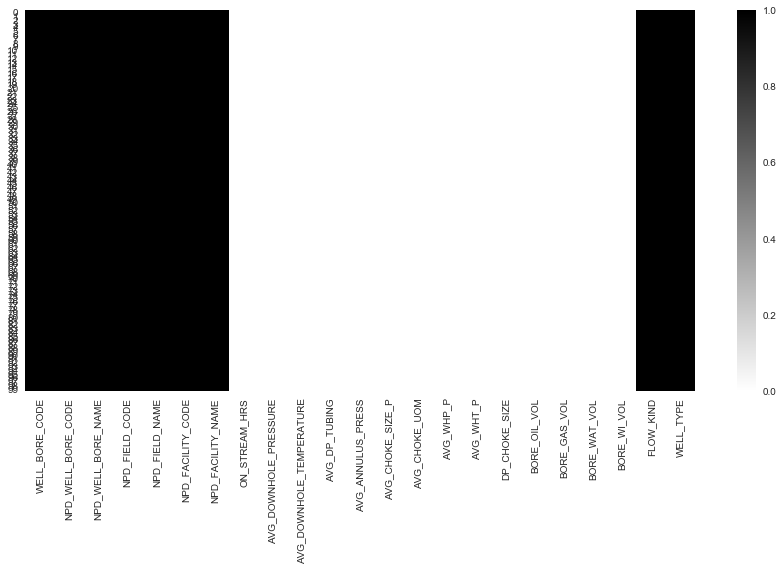

In [13]:
# Count nulls
null_count = original_data.isnull().sum()
null_count[null_count>0]

plt.figure(figsize=(15,7))
sns.heatmap(~original_data.reset_index(drop=True).iloc[0:100].isnull(), cmap='gray_r')

In [14]:
# Fill NAs with zero
original_data = original_data.fillna(0)

In [15]:
# Drop not useful columns
original_data = original_data.drop(['NPD_FIELD_CODE','NPD_FIELD_NAME','NPD_FACILITY_CODE'], axis=1)

In [16]:
# Create cumulitive volumes
original_data['MILL_BORE_OIL_VOL_CUME']=original_data['BORE_OIL_VOL'].cumsum()* 0.000001
original_data['MILL_BORE_GAS_VOL_CUME']=original_data['BORE_GAS_VOL'].cumsum()* 0.000001
original_data['MILL_BORE_WAT_VOL_CUME']=original_data['BORE_WAT_VOL'].cumsum()* 0.000001
original_data['BOEPD_PRODUCED_VOL']= \
    (original_data['BORE_OIL_VOL']+0.05*original_data['BORE_GAS_VOL']+original_data['BORE_WAT_VOL'])
original_data['MILL_BOEPD_PRODUCED_CUME']=original_data['BOEPD_PRODUCED_VOL'].cumsum() * 0.000001

# Add a binary column showing if production BOEPD >= 3K
original_data['MIN_3K_BOEPD_BINARY'] = np.where(original_data['BOEPD_PRODUCED_VOL']  >= 3000, 1,0)

In [17]:
# Focus only the most productive well = NPD Well Bore Code 5599
original_data = original_data[original_data['NPD_WELL_BORE_CODE'] == 5599]

In [18]:
original_data.head()

,WELL_BORE_CODE,NPD_WELL_BORE_CODE,NPD_WELL_BORE_NAME,NPD_FACILITY_NAME,ON_STREAM_HRS,AVG_DOWNHOLE_PRESSURE,AVG_DOWNHOLE_TEMPERATURE,AVG_DP_TUBING,AVG_ANNULUS_PRESS,AVG_CHOKE_SIZE_P,...,BORE_WAT_VOL,BORE_WI_VOL,FLOW_KIND,WELL_TYPE,MILL_BORE_OIL_VOL_CUME,MILL_BORE_GAS_VOL_CUME,MILL_BORE_WAT_VOL_CUME,BOEPD_PRODUCED_VOL,MILL_BOEPD_PRODUCED_CUME,MIN_3K_BOEPD_BINARY
DATETIME,,,,,,,,,,,,,,,,,,,,,
2008-02-12,NO 15/9-F-12 H,5599,15/9-F-12,MÆRSK INSPIRER,11.50,308.055940,104.418090,201.250000,18.639557,14.484431,...,385.01,0.0,production,OP,0.000285,0.038889,0.000385,2614.0935,0.002614,0
2008-02-13,NO 15/9-F-12 H,5599,15/9-F-12,MÆRSK INSPIRER,24.00,303.033518,105.402696,182.144942,16.466641,22.832986,...,7.13,0.0,production,OP,0.002154,0.324135,0.000392,16139.1380,0.018753,1
2008-02-14,NO 15/9-F-12 H,5599,15/9-F-12,MÆRSK INSPIRER,22.50,295.586061,105.775486,181.867887,12.659589,31.249966,...,1.16,0.0,production,OP,0.005278,0.834090,0.000393,28622.9940,0.047376,1
2008-02-15,NO 15/9-F-12 H,5599,15/9-F-12,MÆRSK INSPIRER,23.15,297.662702,105.751875,180.832060,5.264052,28.518930,...,0.97,0.0,production,OP,0.007887,1.217516,0.000394,21780.5835,0.069157,1
2008-02-16,NO 15/9-F-12 H,5599,15/9-F-12,MÆRSK INSPIRER,24.00,295.935519,105.811114,180.501045,12.384634,30.227902,...,4.89,0.0,production,OP,0.010939,1.635990,0.000399,23980.3900,0.093137,1


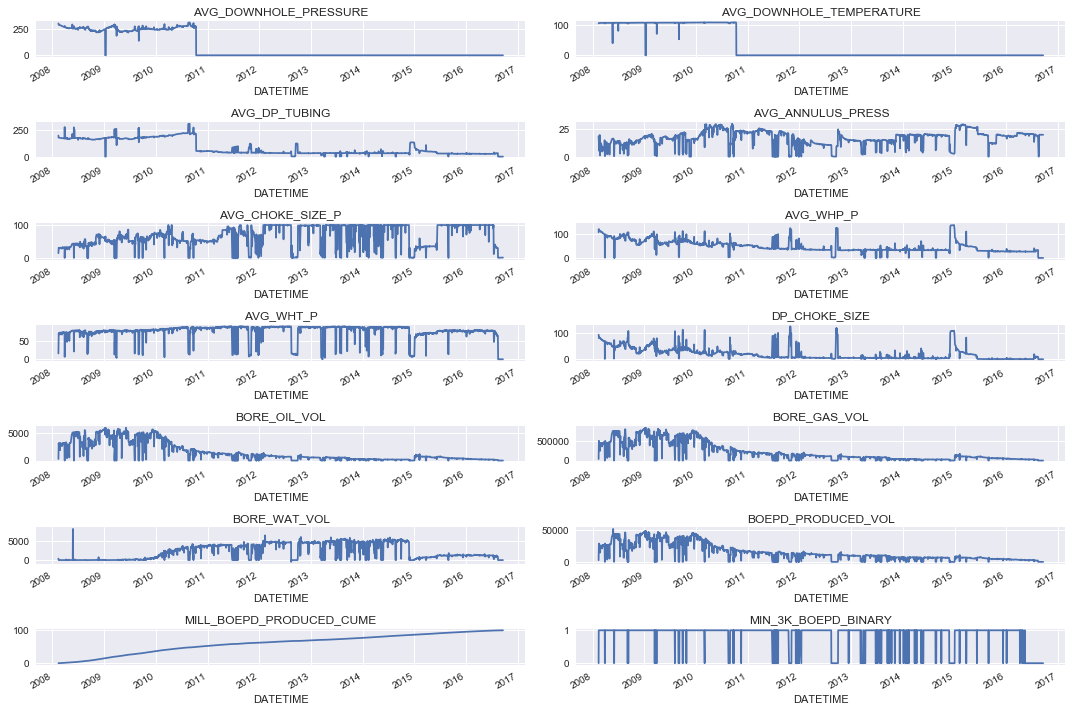

In [19]:
plt.figure(1)
plt.subplot(7,2,1)
original_data.AVG_DOWNHOLE_PRESSURE.plot( figsize=(15,10), title='AVG_DOWNHOLE_PRESSURE') 
plt.subplot(7,2,2)
original_data.AVG_DOWNHOLE_TEMPERATURE.plot( figsize=(15,10), title='AVG_DOWNHOLE_TEMPERATURE') 
plt.subplot(7,2,3)
original_data.AVG_DP_TUBING.plot( figsize=(15,10), title='AVG_DP_TUBING') 
plt.subplot(7,2,4)
original_data.AVG_ANNULUS_PRESS.plot( figsize=(15,10), title='AVG_ANNULUS_PRESS') 
plt.subplot(7,2,5)
original_data.AVG_CHOKE_SIZE_P.plot( figsize=(15,10), title='AVG_CHOKE_SIZE_P') 
plt.subplot(7,2,6)
original_data.AVG_WHP_P.plot( figsize=(15,10), title='AVG_WHP_P') 
plt.subplot(7,2,7)
original_data.AVG_WHT_P.plot( figsize=(15,10), title='AVG_WHT_P') 
plt.subplot(7,2,8)
original_data.DP_CHOKE_SIZE.plot( figsize=(15,10), title='DP_CHOKE_SIZE') 
plt.subplot(7,2,9)
original_data.BORE_OIL_VOL.plot( figsize=(15,10), title='BORE_OIL_VOL') 
plt.subplot(7,2,10)
original_data.BORE_GAS_VOL.plot( figsize=(15,10), title='BORE_GAS_VOL') 
plt.subplot(7,2,11)
original_data.BORE_WAT_VOL.plot( figsize=(15,10), title='BORE_WAT_VOL') 
plt.subplot(7,2,12)
original_data.BOEPD_PRODUCED_VOL.plot( figsize=(15,10), title='BOEPD_PRODUCED_VOL') 
plt.subplot(7,2,13)
original_data.MILL_BOEPD_PRODUCED_CUME.plot( figsize=(15,10), title='MILL_BOEPD_PRODUCED_CUME') 
plt.subplot(7,2,14)
original_data.MIN_3K_BOEPD_BINARY.plot( figsize=(15,10), title='MIN_3K_BOEPD_BINARY') 

plt.tight_layout()

In [20]:
# Create x and y values
X = original_data[features].copy()
y = original_data[target].copy()

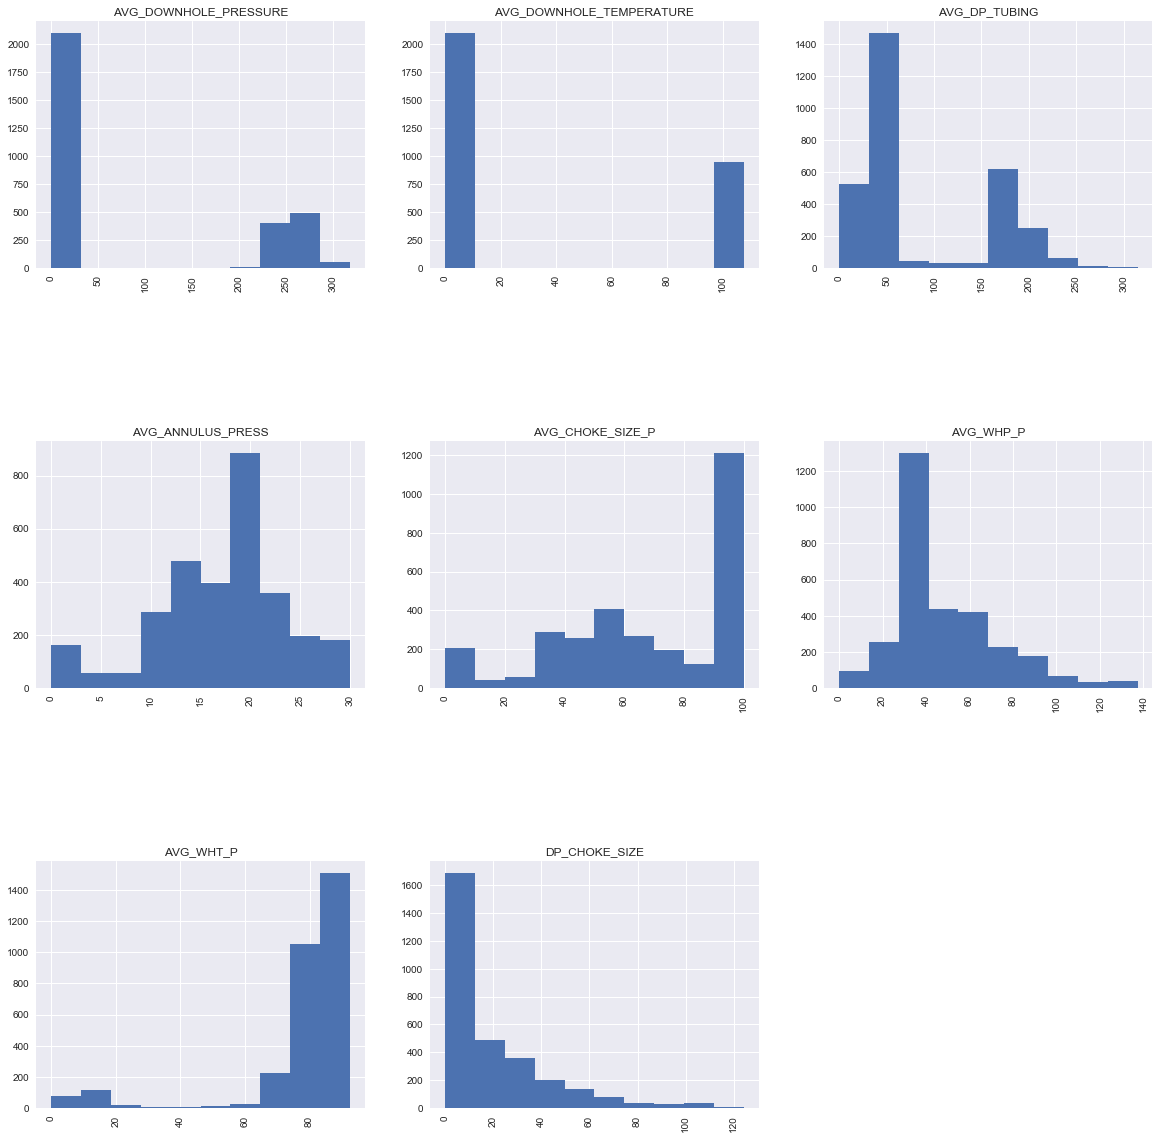

In [21]:
# Additional plot
fig = plt.figure(figsize=(20,20))
cols = 3
rows = math.ceil(float(X.shape[1]) / cols)

for i, column in enumerate(['AVG_DOWNHOLE_PRESSURE', 'AVG_DOWNHOLE_TEMPERATURE',
                            'AVG_DP_TUBING','AVG_ANNULUS_PRESS', 'AVG_CHOKE_SIZE_P',
                            'AVG_WHP_P','AVG_WHT_P', 'DP_CHOKE_SIZE']):
    ax = fig.add_subplot(rows, cols, i + 1)
    ax.set_title(column)
    if X.dtypes[column] == np.object:
        X[column].value_counts().plot(kind="bar", axes=ax)
    else:
        X[column].hist(axes=ax)
        plt.xticks(rotation="vertical")
plt.subplots_adjust(hspace=0.7, wspace=0.2)
plt.show()

**Note**: AVG_DOWNHOLE_TEMPERATURE is weird, lots of 0 values...

In [22]:
# Create multi-step or sequence forecasting. 
def series_to_supervised(dfin, n_past_in=10, n_past_end=0, n_past_step=1):
    """extract all features from t-np_past_in to t-n_past_end days to actual day to forecast
    
    dfin:       input dataframe
    n_past_in:  max lag for past days to use in prediction
    n_past_end: min lag for past days to use in prediction
    dropnan:    drop rows with nans
    
    agg:        output datafram
    """
    df=dfin.copy()    
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_past_in, n_past_end-1, -n_past_step):
        cols.append(df.shift(i))
        if i==0:
            names += [('%s(t)' % j) for j in df.columns]
        else:
            names += [('%s(t-%d)' % (j, i)) for j in df.columns]

    # put it all together
    if len(cols)==1:
        agg = cols[0]
    else:        
        agg = pd.concat(cols, axis=1)
    agg.columns = names
    return agg

In [23]:
x_data = series_to_supervised(X, n_past_in=n_past_in,n_past_end=n_past_end,n_past_step=n_past_step) 
x_data.head(5)

,AVG_DOWNHOLE_PRESSURE(t-20),AVG_DOWNHOLE_TEMPERATURE(t-20),AVG_DP_TUBING(t-20),AVG_ANNULUS_PRESS(t-20),AVG_CHOKE_SIZE_P(t-20),AVG_WHP_P(t-20),AVG_WHT_P(t-20),DP_CHOKE_SIZE(t-20),AVG_DOWNHOLE_PRESSURE(t-19),AVG_DOWNHOLE_TEMPERATURE(t-19),...,AVG_WHT_P(t-1),DP_CHOKE_SIZE(t-1),AVG_DOWNHOLE_PRESSURE(t),AVG_DOWNHOLE_TEMPERATURE(t),AVG_DP_TUBING(t),AVG_ANNULUS_PRESS(t),AVG_CHOKE_SIZE_P(t),AVG_WHP_P(t),AVG_WHT_P(t),DP_CHOKE_SIZE(t)
DATETIME,,,,,,,,,,,,,,,,,,,,,
2008-02-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,308.055940,104.418090,201.250000,18.639557,14.484431,106.805939,16.294718,92.475107
2008-02-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,16.294718,92.475107,303.033518,105.402696,182.144942,16.466641,22.832986,120.888576,53.374330,89.620148
2008-02-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,53.374330,89.620148,295.586061,105.775486,181.867887,12.659589,31.249966,113.718175,72.737631,80.120465
2008-02-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,72.737631,80.120465,297.662702,105.751875,180.832060,5.264052,28.518930,116.830642,69.995943,84.250990
2008-02-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,69.995943,84.250990,295.935519,105.811114,180.501045,12.384634,30.227902,115.434474,71.518347,82.359026


In [24]:
#y_data = series_to_supervised(y,0)  # Current day target
y_data = y.copy()
display(y_data.head(5))

#(y['MIN_3K_BOEPD_BINARY']-y_data['MIN_3K_BOEPD_BINARY(t)']).sum()

,MIN_3K_BOEPD_BINARY
DATETIME,
2008-02-12,0
2008-02-13,1
2008-02-14,1
2008-02-15,1
2008-02-16,1


In [25]:
# drop rows with nans (where shift back was not possible)
chosen = ~(x_data.isnull().sum(axis=1).values>0)
x_data = x_data[chosen]
y_data = y_data[chosen]

In [26]:
display(x_data.head(5))
display(y_data.head(5))

,AVG_DOWNHOLE_PRESSURE(t-20),AVG_DOWNHOLE_TEMPERATURE(t-20),AVG_DP_TUBING(t-20),AVG_ANNULUS_PRESS(t-20),AVG_CHOKE_SIZE_P(t-20),AVG_WHP_P(t-20),AVG_WHT_P(t-20),DP_CHOKE_SIZE(t-20),AVG_DOWNHOLE_PRESSURE(t-19),AVG_DOWNHOLE_TEMPERATURE(t-19),...,AVG_WHT_P(t-1),DP_CHOKE_SIZE(t-1),AVG_DOWNHOLE_PRESSURE(t),AVG_DOWNHOLE_TEMPERATURE(t),AVG_DP_TUBING(t),AVG_ANNULUS_PRESS(t),AVG_CHOKE_SIZE_P(t),AVG_WHP_P(t),AVG_WHT_P(t),DP_CHOKE_SIZE(t)
DATETIME,,,,,,,,,,,,,,,,,,,,,
2008-03-03,308.055940,104.418090,201.250000,18.639557,14.484431,106.805939,16.294718,92.475107,303.033518,105.402696,...,75.218382,74.761624,285.727865,105.910122,177.668621,10.866488,30.964472,108.059244,75.124268,74.360597
2008-03-04,303.033518,105.402696,182.144942,16.466641,22.832986,120.888576,53.374330,89.620148,295.586061,105.775486,...,75.124268,74.360597,285.381996,105.903653,177.306881,9.828945,30.602215,108.075115,74.280982,74.440533
2008-03-05,295.586061,105.775486,181.867887,12.659589,31.249966,113.718175,72.737631,80.120465,297.662702,105.751875,...,74.280982,74.440533,284.828875,105.901837,176.959589,9.322770,30.576489,107.869286,72.500005,74.262442
2008-03-06,297.662702,105.751875,180.832060,5.264052,28.518930,116.830642,69.995943,84.250990,295.935519,105.811114,...,72.500005,74.262442,284.294744,105.898924,176.984357,9.113610,30.588812,107.310387,75.002263,73.374819
2008-03-07,295.935519,105.811114,180.501045,12.384634,30.227902,115.434474,71.518347,82.359026,295.551657,105.831299,...,75.002263,73.374819,284.423682,105.878153,176.669994,6.275874,28.824959,107.753688,71.041615,73.568443


,MIN_3K_BOEPD_BINARY
DATETIME,
2008-03-03,1
2008-03-04,1
2008-03-05,1
2008-03-06,1
2008-03-07,1


In [27]:
x_data.shape, y_data.shape # Check to make sure dimensions are right size

((3036, 168), (3036, 1))

In [28]:
(pd.concat([x_data,y_data],axis=1).corr()).iloc[-1]

AVG_DOWNHOLE_PRESSURE(t-20)       0.176032
AVG_DOWNHOLE_TEMPERATURE(t-20)    0.179113
AVG_DP_TUBING(t-20)               0.189611
AVG_ANNULUS_PRESS(t-20)           0.019318
AVG_CHOKE_SIZE_P(t-20)           -0.025600
AVG_WHP_P(t-20)                   0.165980
AVG_WHT_P(t-20)                   0.109834
DP_CHOKE_SIZE(t-20)               0.120026
AVG_DOWNHOLE_PRESSURE(t-19)       0.176126
AVG_DOWNHOLE_TEMPERATURE(t-19)    0.178857
AVG_DP_TUBING(t-19)               0.188319
AVG_ANNULUS_PRESS(t-19)           0.024917
AVG_CHOKE_SIZE_P(t-19)           -0.018645
AVG_WHP_P(t-19)                   0.165543
AVG_WHT_P(t-19)                   0.122035
DP_CHOKE_SIZE(t-19)               0.118370
AVG_DOWNHOLE_PRESSURE(t-18)       0.175976
AVG_DOWNHOLE_TEMPERATURE(t-18)    0.178634
AVG_DP_TUBING(t-18)               0.188608
AVG_ANNULUS_PRESS(t-18)           0.026878
AVG_CHOKE_SIZE_P(t-18)           -0.010236
AVG_WHP_P(t-18)                   0.167434
AVG_WHT_P(t-18)                   0.130567
DP_CHOKE_SI

In [29]:
# Check correlations
(pd.concat([x_data,y_data],axis=1).corr()).iloc[-1].sort_values(ascending=False)

MIN_3K_BOEPD_BINARY        1.000000
AVG_WHT_P(t)               0.735888
AVG_WHT_P(t-1)             0.608944
AVG_WHT_P(t-2)             0.518882
AVG_CHOKE_SIZE_P(t)        0.507473
AVG_WHT_P(t-3)             0.484913
AVG_WHT_P(t-4)             0.424701
AVG_ANNULUS_PRESS(t)       0.409987
AVG_WHT_P(t-5)             0.400069
AVG_CHOKE_SIZE_P(t-1)      0.393889
AVG_WHT_P(t-6)             0.369244
AVG_WHT_P(t-7)             0.342966
AVG_WHT_P(t-8)             0.325503
AVG_CHOKE_SIZE_P(t-2)      0.315871
AVG_ANNULUS_PRESS(t-1)     0.314569
AVG_WHT_P(t-9)             0.302560
AVG_CHOKE_SIZE_P(t-3)      0.288530
AVG_WHT_P(t-10)            0.278656
AVG_ANNULUS_PRESS(t-2)     0.266412
AVG_WHT_P(t-11)            0.257670
AVG_WHT_P(t-12)            0.255774
AVG_CHOKE_SIZE_P(t-4)      0.241976
AVG_ANNULUS_PRESS(t-3)     0.240813
AVG_WHT_P(t-13)            0.239665
AVG_CHOKE_SIZE_P(t-5)      0.218864
AVG_WHT_P(t-14)            0.211813
AVG_ANNULUS_PRESS(t-4)     0.203849
AVG_CHOKE_SIZE_P(t-6)      0

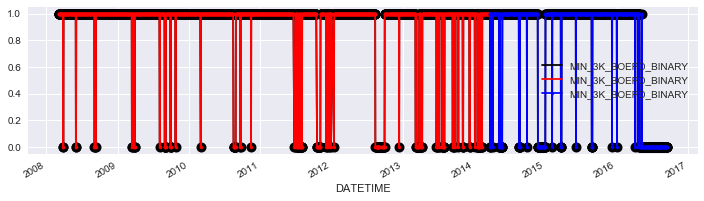

In [30]:
if shuffle:
    # Spliting into 70% for training set and 30% for testing (random)
    X_train, X_test, y_train, y_test = train_test_split(x_data, y_data[target], 
                                                        test_size=0.3, random_state=0)
else:
    # Spliting into 70% for training set and 30% for testing (sequential)
    train_to_test = int(0.7*x_data.shape[0])
    X_train = x_data[:train_to_test]
    X_test  = x_data[train_to_test:]
    y_train = y_data[target][:train_to_test]
    y_test  = y_data[target][train_to_test:]
fig, ax = plt.subplots(figsize=(12,3))
y_data.plot(kind='line',  ax=ax, style='.-k', ms=20)
y_train.plot(kind='line', ax=ax, style='.-r')
y_test.plot(kind='line',  ax=ax, style='.-b');

## ML prediction

Single test-train split

score 0.74


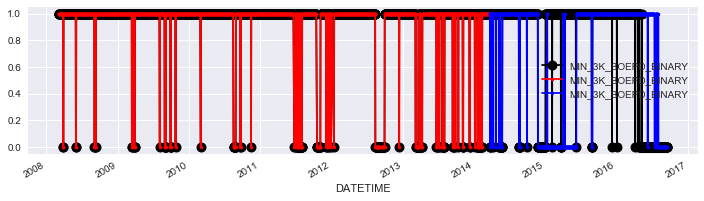

In [31]:
# Fitting the data.
classifier.fit(X_train, y_train.values.ravel())

# Predicting the result and giving the accuracy
score = classifier.score(X_test, y_test.values)
print('score %.2f' % score)

y_train_pred    = y_train.copy()
y_test_pred     = y_test.copy()
y_train_pred[:] = classifier.predict(X_train)[:,np.newaxis]
y_test_pred[:]  = classifier.predict(X_test)[:,np.newaxis]

fig, ax = plt.subplots(figsize=(12,3))
y_data.plot(kind='line',  ax=ax, style='.-k', ms=20)
y_train_pred.plot(kind='line', ax=ax, style='.-r', label='TRAIN')
y_test_pred.plot(kind='line',  ax=ax, style='.-b', label='TEST')
plt.legend()

In [32]:
if classification:
    print ("Classifier - Train Confusion Matrix\n\n%s" % pd.crosstab(y_train.values, classifier.predict(X_train),rownames = ["Actual"],colnames = ["Predicted"]) )      
    print("\n##############################################")
    print ("\Classifier - Train accuracy:",accuracy_score(y_train.values, classifier.predict(X_train))) 
    print("\n##############################################")
    print ('Classifier - Train Classification Report\n%s' % classification_report(y_train.values, classifier.predict(X_train))) 
    print("\n##############################################")
else:
    print ("Regressor - Test Percent MSE %.2f %%" % 
           (100.*(np.sqrt(np.mean((y_train.values-classifier.predict(X_train))**2))/np.sqrt(np.mean(y_train.values**2)))))

NameError: name 'classification' is not defined

In [ ]:
if classification:
    print ("Classifier - Test Confusion Matrix\n\n%s" % pd.crosstab(y_test.values, classifier.predict(X_test),rownames = ["Actual"],colnames = ["Predicted"]) )      
    print("\n##############################################")
    print ("\Classifier - Test accuracy:",accuracy_score(y_test.values, classifier.predict(X_test))) 
    print("\n##############################################")
    print ('Classifier - Test Classification Report\n%s' % classification_report(y_test.values,classifier.predict(X_test))) 
    print("\n##############################################")
else:
    print ("Regressor - Test Percent MSE %.2f %%" % 
           (100.*(np.sqrt(np.mean((y_test.values-classifier.predict(X_test))**2))/np.sqrt(np.mean(y_test.values**2)))))

Crossvalidation with no reshuffling in train-test split:

In [ ]:
scores = cross_val_score(classifier, x_data, y_data[target].values.ravel(), 
                         cv=KFold(n_splits=3, shuffle=shuffle, random_state=0))
print('scores',scores)
print('mean score %.2f' % np.mean(scores))

In [ ]:
kf = KFold(n_splits=3, shuffle=shuffle, random_state=0)
scores=[]
for i, (train_index, test_index) in enumerate(kf.split(x_data)):
    X_train, X_test = x_data.iloc[train_index], x_data.iloc[test_index]
    y_train, y_test = y_data[target].iloc[train_index], y_data[target].iloc[test_index]
    
    #fig, ax = plt.subplots(figsize=(12,3))
    #fig.suptitle('SPLITTING %d' %i)
    #y_data.plot(kind='line',  ax=ax, style='k')
    #y_train.plot(kind='line', ax=ax, style='--r')
    #y_test.plot(kind='line',  ax=ax, style='--b')
    
    # Fitting the data.
    classifier.fit(X_train, y_train.values.ravel())

    # Predicting the result and giving the accuracy
    scores.append(classifier.score(X_test, y_test.values.ravel()))
    
    y_train_pred   = y_train.copy()
    y_test_pred    = y_test.copy()
    y_train_pred[:]= classifier.predict(X_train)[:,np.newaxis]
    y_test_pred[:] = classifier.predict(X_test)[:,np.newaxis]

    fig, ax = plt.subplots(figsize=(12,3))
    fig.suptitle('ESTIMATES %d' %i)
    y_data.plot(kind='line',  ax=ax, style='.-k', ms=20)
    y_train_pred.plot(kind='line', ax=ax, style='.-r', label='TRAIN')
    y_test_pred.plot(kind='line',  ax=ax, style='.-b', label='TEST');
    plt.legend()
    
print('scores',scores)
print('mean score %.2f' % np.mean(scores))